In [11]:
#Simulation Functions
from numpy import *
from matplotlib.pyplot import *

def coins(Matrix):
    if Matrix == "H":
        coin = array([[1/sqrt(2) , 1/sqrt(2)],[1/sqrt(2) , -1/sqrt(2)]])
    elif Matrix == "X":
        coin = array([0,1],[1,0])
    return coin

def init_state(N,P,CoinState):
    initstate = zeros((N,1))
    initstate[P][0] = 1
    g = kron(CoinState,initstate)
    return g

def init_coin(init):
    if init == "0":
        psi0 = array([[1],[0]])
    if init == "1":
        psi0 = array([[0],[1]])
    if init == "01":
        psi0 = array([[1/sqrt(2)],[(-1*1j)/sqrt(2)]])
    return psi0

def walk_op(N,state0,state1):
    c00= outer(state0,state0)
    c01= outer(state0,state1)
    c10= outer(state1,state0)
    c11= outer(state1,state1)
    ShiftPlus = roll(eye(N),1,axis=0)
    ShiftMinus = roll(eye(N),-1,axis=0)
    Shift = kron(c00,ShiftPlus) + kron(c11,ShiftMinus) 
    return Shift

def CU_op(coin, shift,N):
    U = shift.dot(kron(coin,eye(N)))
    return U

def final_state(U,psi0,steps):
    for t in range(0,steps):
        psi0=U.dot(psi0)
    return psi0

def prob_vec(psiN,N):
    probs = zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*conjugate(psiN[x]) + psiN[N+x]*conjugate(psiN[N+x]) #duvida aqui
    return probs

def cqwalk(N,steps,coinstate):
    P = int((N+1)/2)
    state0 = array([1,0])
    state1 = array([0,1])
    Coin = coins("H")
    shift= walk_op(N,state0,state1)
    U = CU_op(Coin,shift,N)
    amp = array([1])
    psi0 = init_state(N,P,coinstate)
    psiN = final_state(U,psi0,steps)
    probvec = prob_vec(psiN,N)
    return probvec

In [12]:
#Qiskit Functions
import sys
sys.path.append('../Tools')
from IBMTools import( 
        simul,
        savefig,
        saveMultipleHist,
        printDict,
        plotMultipleQiskit,
        plotMultipleQiskitIbm,
        plotMultipleQiskitIbmSim,
        multResultsSim,
        setProvider,
        leastBusy,
        listBackends,
        getJob)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from math import (log,ceil)
plt.rcParams['figure.figsize'] = 11,8
matplotlib.rcParams.update({'font.size' : 15})


#CNot decomposition
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu(np.pi/2, 0, 0,0, qubits[-2],qubits[-1])
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        #B matrix (cry again, but opposite angle)
        qc.cu(-np.pi/2, 0, 0,0, qubits[-2], qubits[-1])
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
   # elif len(qubits)==3:
   #     qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
    return qc

def incr(qwc,q,subnode,n):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.barrier()
        else:
            cnx(qwc,subnode[0],*q[-1:j:-1])
           # qwc.barrier()
    return qwc

def decr(qwc,q,subnode,n):
    qwc.x(subnode[0])
    c=0
    qwc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qwc,subnode[0],*q[-1::-1])
            qwc.x(q[c])
            #qwc.barrier()
        else:
            c+=1
            cnx(qwc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            qwc.x(q[c])
            #qwc.barrier()
    qwc.x(subnode[0])
    return qwc

def incrCirc(qc,q,subnode,n,toGate):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qc,subnode[0],*q[-1::-1])
        else:
            cnx(qc,subnode[0],*q[-1:j:-1])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INC      '
    return qc

def decrCirc(qc,q,subnode,n,toGate):
    qc.x(subnode[0])
    c=0
    qc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qc,subnode[0],*q[-1::-1])
            qc.x(q[c])
        else:
            c+=1
            cnx(qc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            qc.x(q[c])
    qc.x(subnode[0])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      DEC      '
    return qc

def runWalk(N,steps,stateVec):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    qwc.x(qreg[0])
    for i in range(0,steps):
        qwc.h(qsub[0])
        qwc.barrier()
        incr(qwc,qreg,qsub,N)
        qwc.barrier()
        decr(qwc,qreg,qsub,N)
        qwc.barrier()
    if not stateVec:
        qwc.measure(qreg,creg)
    return qwc


def runMultipleWalks(N,steps,stateVec):
    "Creates several instances of the coined quantum walk circuit."
    circList = []
    circListAux = []
    for n in N:
        qreg = QuantumRegister(n)
        qsub = QuantumRegister(1)
        creg = ClassicalRegister(n)
        for step in steps:
            circ = QuantumCircuit(qreg,qsub,creg)
            circ = runWalk(n,step,stateVec)
            circListAux.append(circ)
        circList.append(circListAux)
        circListAux = []
    return circList

def runMultipleWalksLite(N,steps,stateVec):
    "Creates several instances of the coined quantum walk circuit."
    circList = []
    circListAux = []
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    for step in steps:
        circ = QuantumCircuit(qreg,qsub,creg)
        circ = runWalk(N,step,stateVec)
        circList.append(circ)
    return circList


def circRunWalk(N,steps,toGate):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N,name='node')
    qsub = QuantumRegister(1, name='coin')
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    incrCirc1 = QuantumCircuit(qreg,qsub)
    decrCirc1 = QuantumCircuit(qreg,qsub)
    incrCirc1 = incrCirc(incrCirc1,qreg,qsub,N,toGate)
    decrCirc1 = decrCirc(decrCirc1,qreg,qsub,N,toGate)
    qwc.x(qreg[0])
    qwc.h(qsub[0])
    qwc.barrier()
    for i in range(0,steps):
        qwc.append(incrCirc1,[N]+list(range(0,N)))
        qwc.append(decrCirc1,[N]+list(range(0,N)))
        qwc.barrier()
        if i!=steps-1:
            qwc.h(qsub[0])
    qwc.measure(qreg,creg)
    return qwc

def initialCond(string,N,toGate):
    qc = QuantumCircuit(N+1)
    for x in range(N):
        print(string[x])
        if string[x] == '1':
            qc.x(x)
    qc.h(N)
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INIT      '
    return qc

def circRunWalk2(N,steps,string,toGate):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N,name='node')
    qsub = QuantumRegister(1, name='coin')
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    incrCirc1 = QuantumCircuit(qreg,qsub)
    decrCirc1 = QuantumCircuit(qreg,qsub)
    incrCirc1 = incrCirc(incrCirc1,qreg,qsub,N,toGate)
    decrCirc1 = decrCirc(decrCirc1,qreg,qsub,N,toGate)
    initCond = initialCond(string,N,True)
    qwc.append(initCond, [N]+list(range(0,N)))
    qwc.barrier()
    for i in range(0,steps):
        qwc.append(incrCirc1,[N]+list(range(0,N)))
        qwc.append(decrCirc1,[N]+list(range(0,N)))
        qwc.barrier()
        if i!=steps-1:
            qwc.h(qsub[0])
    qwc.measure(qreg,creg)
    return qwc

def circRunMultipleWalks(N,steps,toGate):
    "Creates several instances of the coined quantum walk circuit."
    circList = []
    circListAux = []
    for n in N:
        qreg = QuantumRegister(n)
        qsub = QuantumRegister(1)
        creg = ClassicalRegister(n)
        for step in steps:
            circ = QuantumCircuit(qreg,qsub,creg)
            circ = circRunWalk(n,step,toGate)
            circListAux.append(circ)
        circList.append(circListAux)
        circListAux = []
    return circList

def saveCoinedWalkFig(N,steps,fig, filePath, defaultFileName):
    specificFileName = ""
    i=0
    for n in N:
        specificFileName+= "N%s_S"%n
        for step in steps:
            specificFileName+="%s"%step
        i+=1
        if(len(N)-i==0):
            break
        specificFileName+="_"
    savefig(fig, filePath,defaultFileName+specificFileName)
    return specificFileName

def printIncr(N,steps,style):
    "Creates a single instance of the coined quantum walk cicuit."
    for n in N:
        qreg = QuantumRegister(n,name='node')
        qsub = QuantumRegister(1, name='coin')
        incrCirc1 = QuantumCircuit(qreg,qsub)
        incrCirc1 = incrCirc(incrCirc1,qreg,qsub,n,False)
        fig = incrCirc1.draw(output='mpl',style=style) 
    return fig 

def printDecr(N,steps,style):
    "Creates a single instance of the coined quantum walk cicuit."
    for n in N:
        qreg = QuantumRegister(n,name='node')
        qsub = QuantumRegister(1, name='coin')
        decrCirc1 = QuantumCircuit(qreg,qsub)
        decrCirc1 = decrCirc(decrCirc1,qreg,qsub,n,False)
        fig = decrCirc1.draw(output='mpl',style=style) 
    return fig 

def drawCirc(circMultWalk,style):
    for circList in circMultWalk:
        for circ in circList:
            fig = circ.draw(output='mpl',style=style)
    return fig

# Quantum Random Walks
## by Jaime Pereira Santos

Fazer introducao com Turing, algoritmos probabilisticos e random walk classica.

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
The space of our quantum walk is composed by coin $\mathcal{H_C}$ and walker spaces $\mathcal{H_W}$, and we have $\mathcal{H} = \mathcal{H_C} \otimes \mathcal{H_W}$.
If the coin is tossed and rolls "heads", for example, the system transitions to position  $\ket{x+1}$ , otherwise it advances to  $\ket{x-1}$.\par
Considering a quantum random walk on a line graph, where each vertex only has 2 neighbors, the coin will be a single qubit unitary operator defined as

\begin{equation}
        \begin{cases}
                C\ket{0}\ket{x} = a\ket{0}\ket{x} + b\ket{1}\ket{x}\\
                C\ket{1}\ket{x} = c\ket{0}\ket{x} + d\ket{1}\ket{x},
        \end{cases}
\end{equation}

where  a ,  b ,  c  and  d  are the amplitudes associated with each outcome of the coin toss. In this example, a balanced coined will be considered, therefore it will simply be the hadamard operator

\begin{equation}
        C_H = \begin{pmatrix} 
                a & c\\
                b & d
            \end{pmatrix}
            =\frac{1}{\sqrt{2}} \begin{pmatrix}
                                        1 & 1\\
                                        1 & -1
                               \end{pmatrix},
\end{equation}


Blablabla

In [13]:
coin = array([[1/sqrt(2) , 1/sqrt(2)],
              [1/sqrt(2), -1/sqrt(2)]
             ])
print(coin)

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


We can describe the shift operator as

\begin{eqnarray}
    S\ket{0}\ket{x} &=& \ket{0}\ket{x+1}\\
    S\ket{1}\ket{x} &=& \ket{1}\ket{x-1} \nonumber
\end{eqnarray}
    
and S in the computational basis has the format
    \begin{eqnarray}
        S = \ket{0}\bra{0} \otimes \sum_{x} \ket{x+1}\bra{x}+ \ket{1}\bra{1} \otimes \sum_{x} \ket{x-1}\bra{x}&& 
    \end{eqnarray}

In [14]:
N = 200
c00 = outer(array([1,0]),array([1,0]))
c11 = outer(array([0,1]),array([0,1])) 

ShiftPlus = roll(eye(N),1,axis=0)
ShiftMinus = roll(eye(N),-1,axis=0)

shift=kron(c00,ShiftPlus) + kron(c11,ShiftMinus)
print(shift)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


It follows that the operator that describes the dynamics of the quantum walk will be given by

\begin{equation}
       U = S(C \otimes I_N) \quad \longrightarrow \quad S(C_H\otimes I)
\end{equation}

In [15]:
U = shift.dot(kron(coin,eye(N)))
print(U)

[[ 0.          0.          0.         ...  0.          0.
   0.70710678]
 [ 0.70710678  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.70710678  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.70710678
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.70710678]
 [ 0.70710678  0.          0.         ...  0.          0.
   0.        ]]


Consider a quantum system located at  $\ket{x = 0}$  with coin state  $\ket{0}$ , for  $t=0$ . It's state will be described by

\begin{equation}
        \ket{\psi(0)} = \ket{0}\ket{x=0}.
        \label{eq:coinedQWInitCond0}
\end{equation}

Applying the unitary evolution operator $t$ times will result in state

\begin{equation}
      \ket{\psi(t)} = U^t\ket{\psi(0) }
\end{equation}

In [19]:
steps = 100
psi0 = init_state(N,int(N/2)+1,init_coin('0'))
for t in range(0,steps):
    psi0=U.dot(psi0)
    psiT = psi0   

The probability distribution is then obtained by the Born rule
 
\begin{equation}
    p(\ket{\psi(t)}) = \lvert \ket{\psi(t)}  \rvert^2
\end{equation}


In [6]:
for x in range(N):
        probs = zeros((N,1))
        probs[x]=psiT[x]*conjugate(psiT[x]) + psiT[N+x]*conjugate(psiT[N+x])

Putting it all together, the _cqwalk_ function (available as notes in this notebook) returns a probability distribution ready to be plotted.

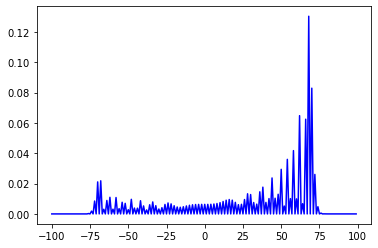

In [22]:
from IPython.display import HTML, display

N = 200
steps = 100

initcondcoin0 = init_coin('0')

qw0 = cqwalk(N,steps,initcondcoin0) 

plot(arange(-N/2,N/2),qw0 ,'b')

The Hadamard operator flips the sign of state $\ket{1}$, hence more terms are cancelled when the coin state is $\ket{1}$. Since $\ket{0}$ was defined to _increment_ state $\ket{x}$, then it is obvious why there is a higher probability of finding the walker in the right-side of the graph.

Following this logic, it would be expected that an initial condition

\begin{equation}
        \ket{\Psi(0)} = \ket{1}\ket{x=0},
        \label{eq:coinedQWInitCond1}
\end{equation}

would result in more cancelations of terms when the coin state is $\ket{0}$, resulting in a drift towards the left-side.

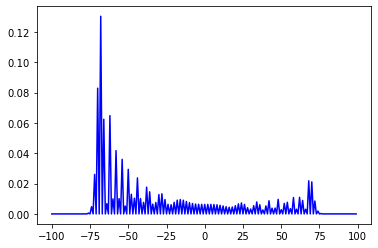

In [17]:
init1 = '1'
initcondcoin1 = init_coin(init1)
qw1 = cqwalk(N,steps,initcondcoin1)

plot(arange(-N/2,N/2),qw1 ,'b')

In order to obtain a symmetrical distribution, one must superpose the state in equation \ref{eq:coinedQWInitCond0} with the state in equation \ref{eq:coinedQWInitCond1}. However, in order to not cancel    terms before the calculation of the probability distribution, one must multiply state $\ket{1}$ with the imaginary unit, $i$

\begin{equation}
        \ket{\Psi(0)} = \frac{\ket{0}-i\ket{1}}{\sqrt{2}}\ket{x=0}.
        \label{eq:12}
\end{equation}


<ipython-input-1-d0808dd6647f>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*conjugate(psiN[x]) + psiN[N+x]*conjugate(psiN[N+x]) #duvida aqui


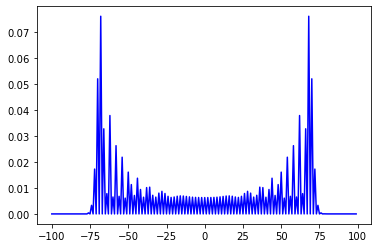

In [15]:
init01 = '01'
initcondcoin01 = init_coin(init01)
qw01 = cqwalk(N,steps,initcondcoin01)

plot(arange(-N/2,N/2),qw01 ,'b')

In [16]:
display(HTML("""
<video width="540" height="380" controls>
  <source src="QuantumWalk500.mp4" type="video/mp4">
</video>
"""))

The probability distribution is now symmetric and it is spread over the range $[-\frac{t}{\sqrt{2}},-\frac{t}{\sqrt{2}}]$ with peaks around $x \approx \pm \frac{t}{\sqrt{2}}$. This means that if t
he position of the walker was measured at the end, it would be equally probable to find him either in the left side or the right side of the graph, which is not possible in a classical diffusive motion.


Escrever sobre desvio padrao e aplicacoes da quantum walk discreta.

Now, the focus is to study a quantum circuit based on the work presented by \cite{douglaswang07}. This approach relies on a set of gates that shift the state of the walker by $+1$ or $-1$, each with a probability associated with the chosen coin.

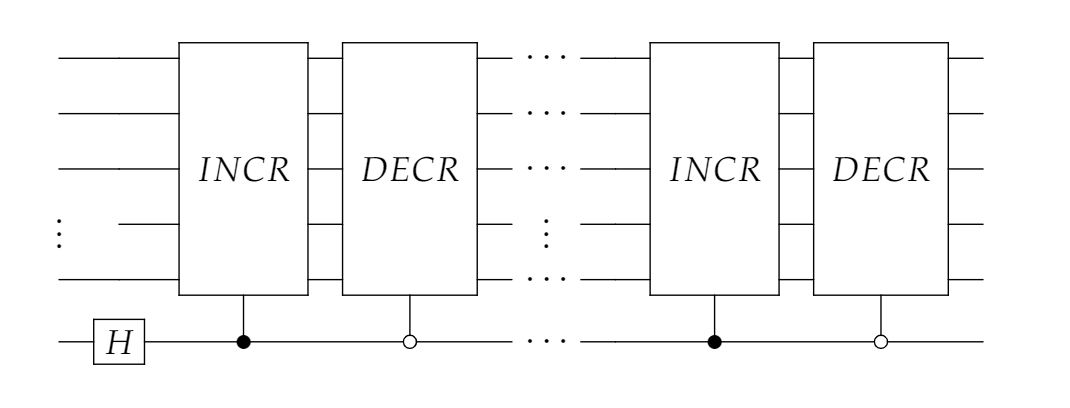

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "dwcircuit.png", width=900, height=600)

The increment gate will be

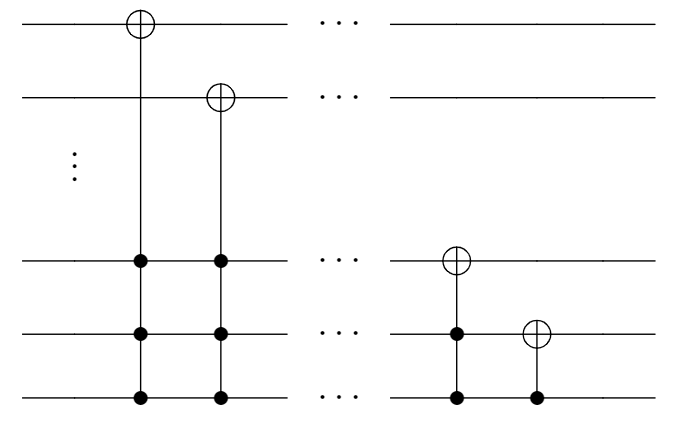

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "dwincrement.png", width=700, height=600)

and the decrement gate

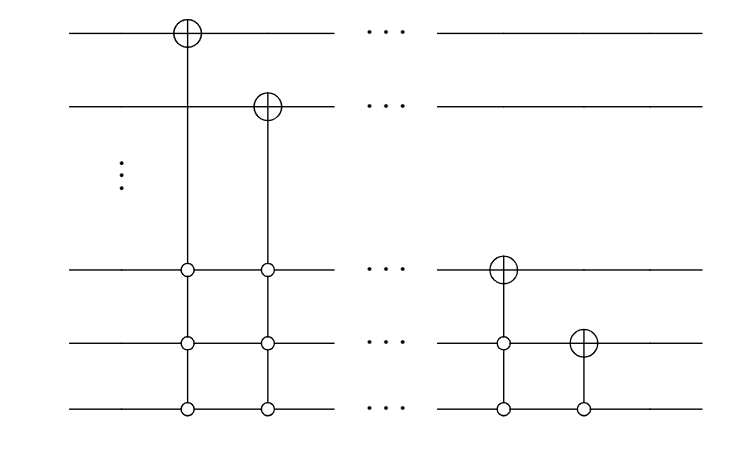

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "dwdecrement.png", width=700, height=600)

The generalized CNOT gates act on the node states as a cyclic permutator, where each node is mapped to an adjacent state. This can be seen as the walker moving left or right, in the uni-dimensional graph example. \par
For a graph with $8$ nodes, for example, $3$ qubits are required to encode every vertex and an extra qubit for the coin. For a 3 step walk, we must build 3 sequences of increment and decrement gates, such as 

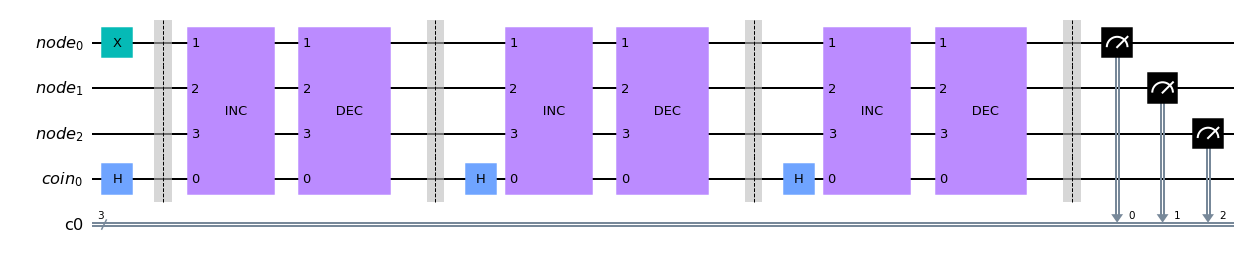

In [5]:
N = 3
steps = 3
display(circRunWalk(N,steps,True).draw(output='mpl'))

In order to implement the Qiskit circuit, we must first find a way of creating generalized CNOT gates. One approach to this problem is to decompose an arbitrarily controlled CNOT gate into elementary gates, as was done by \cite{barenco95}. In this context, the main idea is that for any unitary operator $U$, there exists operators such that

\begin{equation}
	U = \phi AXBXC,
\end{equation}

where $ABC=I$, $X$ is the Pauli-X and $\phi$ is a phase operator described by $\phi=e^{i\delta} \times I$.

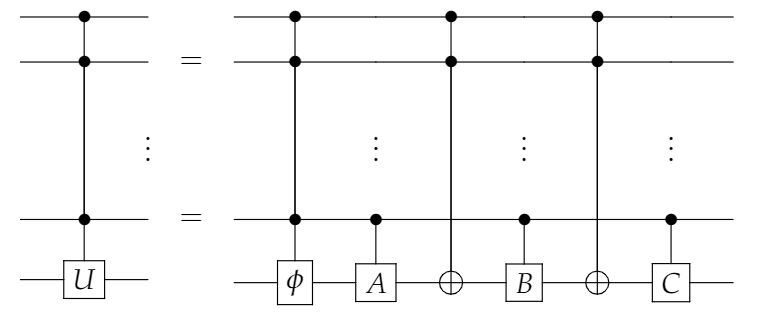

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "cnotdecomp.png", width=900, height=800)

# References

(<a id="cit-douglaswang07" href="#call-douglaswang07">Douglas and B., 2009</a>) Douglas B.L. and B. J., ``_Efficient quantum circuit implementation of quantum walks_'', , vol. , number , pp. ,  2009.

(<a id="cit-barenco95" href="#call-barenco95">Barenco, Bennett <em>et al.</em>, 1995</a>) Barenco Adriano, Bennett Charles H., Cleve Richard <em>et al.</em>, ``_Elementary gates for quantum computation_'', Physical Review A, vol. 52, number 5, pp. 3457–3467, Nov 1995.  [online](http://dx.doi.org/10.1103/PhysRevA.52.3457)

